## Lang-SAM with rectified panoamic images

####Clone the Lang-SAM model

In [1]:
!pip install torch torchvision
!pip install -U git+https://github.com/luca-medeiros/lang-segment-anything.git

  Cloning https://github.com/luca-medeiros/lang-segment-anything.git to /tmp/pip-req-build-7bwtgmsn
  Running command git clone --filter=blob:none --quiet https://github.com/luca-medeiros/lang-segment-anything.git /tmp/pip-req-build-7bwtgmsn
  Resolved https://github.com/luca-medeiros/lang-segment-anything.git to commit fcdb92f9ae4ac3a5b4e5fd85c1576e09132f10bc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/IDEA-Research/GroundingDINO.git to /tmp/pip-install-1odkqd2y/groundingdino_52b3541adf804953b085f1f183c8dc23
  Running command git clone --filter=blob:none --quiet https://github.com/IDEA-Research/GroundingDINO.git /tmp/pip-install-1odkqd2y/groundingdino_52b3541adf804953b085f1f183c8dc23
  Resolved https://github.com/IDEA-Research/GroundingDINO.git to commit 60d796825e1266e56f7e4e9e00e88de662b67bd3
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/fac

####Initialize the Package and LangSAM model

In [2]:
from PIL import Image
from lang_sam import LangSAM

/usr/local/lib/python3.10/dist-packages/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


In [3]:
model = LangSAM()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


Downloading: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth" to /root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth
100%|██████████| 2.39G/2.39G [00:22<00:00, 115MB/s]


####Individual Tree semantic segmentation from Lang-SAM (Around 3 mins)

In [14]:
image = Image.open("/content/tree-sample001.jpg").convert("RGB")

In [15]:
masks, boxes, phrases, logits = model.predict(image, "tree")

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:874: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [28]:
import matplotlib.pyplot as plt
import numpy as np

####Semantic segmentation result

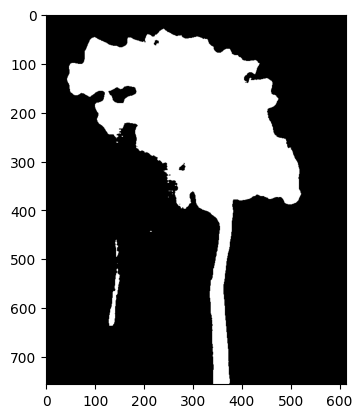

In [31]:
mask = masks[0]
plt.imshow(mask, cmap='gray')
plt.show()

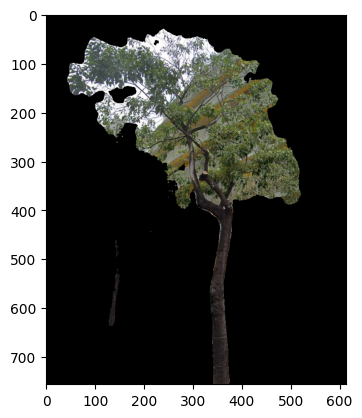

In [30]:
image_arr = np.array(image)
masked_image = np.zeros_like(image_arr)
masked_image[mask>0] = image_arr[mask>0]
masked_img = Image.fromarray(masked_image.astype('uint8'))

masked_img.save('masked_image.png')

plt.imshow(masked_img)
plt.show()

####Clone the Tree Vision package

In [41]:
!git clone https://github.com/ottoykh/Tree-vision.git

Cloning into 'Tree-vision'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 27 (delta 3), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (27/27), 7.48 KiB | 1.50 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [42]:
cd /content/Tree-vision/TreeVision/TreeAI

/content/Tree-vision/TreeVision/TreeAI


In [43]:
from Diagnosis import TreeAI, TreeAI_Batch

####Tree defects detection with the Lang-SAM segmented images and TreeAI

Prediction: Lion’s tailing 獅尾 , 0.702689528465271 %
Prediction: Heavy lateral limb 重側枝 , 0.13113640248775482 %
Prediction: Crooks abrupt bends 不常規彎曲 , 0.03008895367383957 %
Prediction: Exposed dead wood 枯幹外露 , 0.01614345796406269 %
Prediction: Bleedingsap flow 滲液 , 0.015771638602018356 %


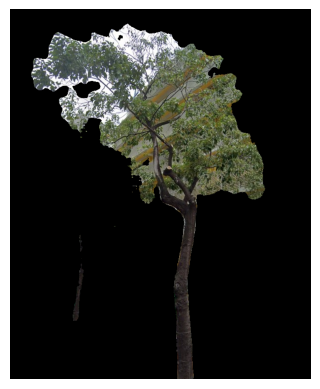

In [48]:
TreeAI("/content/masked_image.png")

####Batch Group Tree semantic segmentation from Lang-SAM

In [53]:
import os
from glob import glob
from pathlib import Path

In [56]:
images_dir = Path('/content/Sample')

def mask_image(image, mask):

  image_arr = np.array(image)
  masked_arr = np.zeros_like(image_arr)

  masked_arr[mask>0] = image_arr[mask>0]
  masked_image = Image.fromarray(masked_arr.astype('uint8'))

  return masked_image

In [57]:
batch_size = 5

for root, dirs, files in os.walk(images_dir):

  for i in range(0, len(files), batch_size):
    images = []

    for f in files[i:i+batch_size]:
      path = os.path.join(root, f)
      image = Image.open(path).convert('RGB')
      images.append(image)

    for j, image in enumerate(images):

      masks, boxes, phrases, logits = model.predict(image, "tree")
      mask = masks[0]
      masked_image = mask_image(image, mask)
      filename = files[i*batch_size + j]
      masked_filename = filename.replace('.jpg', '_masked.png')
      save_path = images_dir / masked_filename
      masked_image.save(str(save_path))
      print("Saved...")

Saved...
Saved...
Saved...
Saved...
Saved...


KeyboardInterrupt: ignored

I have manually stopped the segmentation process.

####Tree defects detection with the Lang-SAM batch segmented images and TreeAI

In [60]:
TreeAI_Batch("/content/Sample/mask","/content/result.csv")

Processing image 1/5...
Processing image 2/5...
Processing image 3/5...
Processing image 4/5...
Processing image 5/5...


In [62]:
import pandas as pd
df = pd.read_csv("/content/result.csv")
print(df)

                       Filename                               Prediction  \
0    tree-sample (9)_masked.png       Signs of pests and disease 呈現病蟲害徵狀   
1    tree-sample (9)_masked.png            Dead branches Hangers 枯死 懸吊斷枝   
2    tree-sample (9)_masked.png                        Cross branches 疊枝   
3    tree-sample (9)_masked.png             Asymmetric tree canopy 樹冠不對稱   
4    tree-sample (9)_masked.png                 Co-dominant branches 等勢枝   
5           tree-sample (8).jpg               Cut pruning roots 根部經切割或截根   
6           tree-sample (8).jpg  Cracks or Fissures on branches 樹幹有裂縫或裂開   
7           tree-sample (8).jpg                Crooks abrupt bends 不常規彎曲   
8           tree-sample (8).jpg          Termites borers injury 白蟻或蛀心蟲蛀蝕   
9           tree-sample (8).jpg                      Cracks splits 裂縫 裂開   
10  tree-sample (13)_masked.png                       Multiple stems 多枝幹   
11  tree-sample (13)_masked.png                   Co-dominant trunks 等勢幹   
12  tree-sam

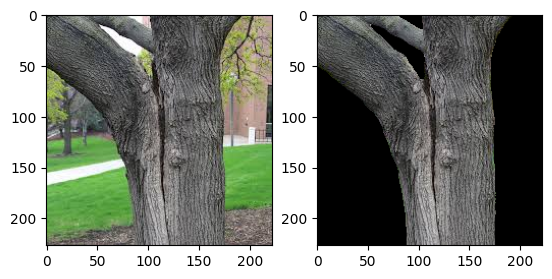

In [63]:
img1 = plt.imread('/content/Sample/tree-sample (13).jpg')
img2 = plt.imread('/content/Sample/mask/tree-sample (13)_masked.png')

fig, axs = plt.subplots(1, 2)
axs[0].imshow(img1)
axs[1].imshow(img2)
plt.show()

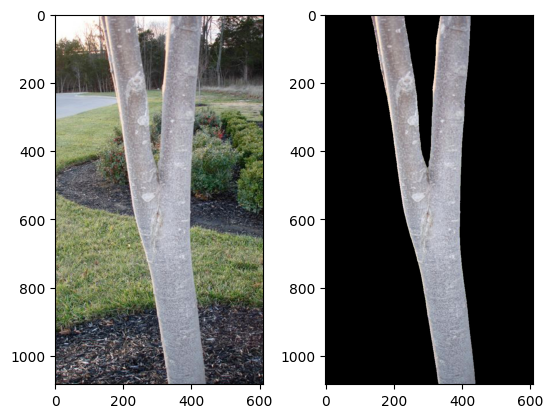

In [64]:
img1 = plt.imread('/content/Sample/tree-sample (10).jpg')
img2 = plt.imread('/content/Sample/mask/tree-sample (10)_masked.png')

fig, axs = plt.subplots(1, 2)
axs[0].imshow(img1)
axs[1].imshow(img2)
plt.show()